<a href="https://colab.research.google.com/github/RMichae1/PyroStudies/blob/master/LSDA_dicts_M5_Forecasting_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel
from pyro.contrib.forecast import Forecaster
from pyro.contrib.forecast import eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.infer.reparam import SymmetricStableReparam
from pyro.infer.reparam import StableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.tensor_utils import periodic_features
from pyro.ops.stats import quantile

import matplotlib.pyplot as plt

In [3]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 23.5MB/s 


In [4]:
%matplotlib inline
pyro.enable_validation(True)
pyro.set_rng_seed(20200502)

NameError: ignored

In [5]:
torch.cuda.is_available()

True

In [23]:
# load data
calendar_df = pd.read_csv("./calendar.csv")
sales_train_val_df = pd.read_csv("./sales_train_validation.csv")
sell_prices_df = pd.read_csv("./sell_prices.csv")

sales_train_val_df.shape

(799, 1919)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

SELECT FROM DATAFRAME:
['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'item_id', 'cat_id']
             item_id   cat_id variable  value
7      HOBBIES_1_008  HOBBIES      d_1   12.0
8      HOBBIES_1_009  HOBBIES      d_1    2.0
14     HOBBIES_1_015  HOB

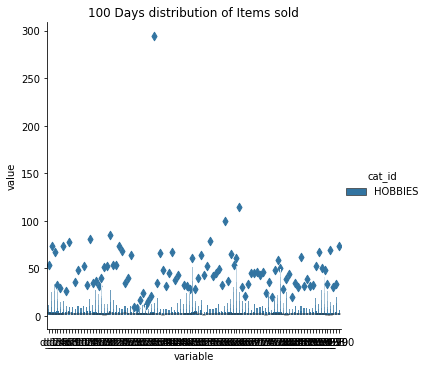

In [9]:
ix_100 = ["d_{}".format(i+1) for i in range(100)]
df_100 = ix_100.copy()
df_100.append("item_id")
df_100.append("cat_id")
print("SELECT FROM DATAFRAME:")
print(df_100)

melt_st_df = pd.melt(sales_train_val_df[df_100], 
                     value_vars=ix_100,
                 id_vars=["item_id", "cat_id"])
item_values_d100 = melt_st_df[melt_st_df["value"]!=0]
item_values_d100 = pd.DataFrame(item_values_d100)
print(item_values_d100)

sns.catplot(x="variable", y="value", kind="boxen",
            hue="cat_id", data=item_values_d100)
plt.title("100 Days distribution of Items sold");

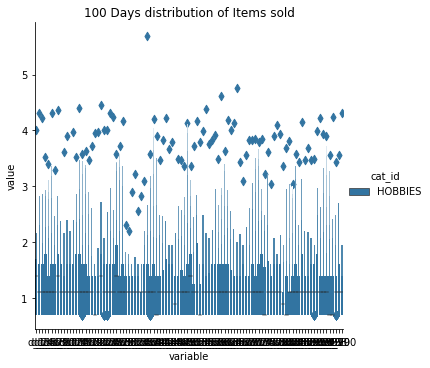

In [10]:
# perform log1p transformation on data
item_values_d100["value"] = np.log1p(item_values_d100["value"])

sns.catplot(x="variable", y="value", kind="boxen",
            hue="cat_id", data=item_values_d100)
plt.title("100 Days distribution of Items sold");

In [11]:
data_days_df = sales_train_val_df.drop(
    columns=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])
data_X = torch.tensor(data_days_df.T.values, dtype=torch.float).log1p()
print(data_X.shape)
data_X

torch.Size([1913, 532])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.6931,  ..., 0.0000, 0.6931,    nan],
        [0.6931, 0.0000, 0.6931,  ..., 0.0000, 0.0000,    nan],
        [0.6931, 0.0000, 0.6931,  ..., 0.6931, 0.0000,    nan]])

In [12]:
D2 = data_X.size(-2)
D1 = D2 - 7 * 2 # two weeks
D0 = D1 - 7 * 175 # train on 100 weeks of data
print("D2 - complete size: {}".format(D2))
print("D1 - two weeks hold out ix: {}".format(D1))
print("D0 - train size ix: {}".format(D0))
# empty covars + plus space for 2 weeks prediction
covariates = torch.zeros(data_X.size(-2), 0)
time = torch.arange(float(D2)) 
covariates = torch.stack([time], dim=-1)
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(D2, 365.25 / 7)], dim=-1)
covariates.shape

D2 - complete size: 1913
D1 - two weeks hold out ix: 1899
D0 - train size ix: 674


torch.Size([1913, 53])

In [0]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
      data_dim = zero_data.size(-1)
      feature_dim = covariates.size(-1)
      bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
      weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

      # We'll sample a time-global scale parameter outside the time plate,
      # then time-local iid noise inside the time plate.
      drift_scale = pyro.sample("drift_scale",
                                dist.LogNormal(-20, 5).expand([1]).to_event(1))
      with self.time_plate:
          # We'll use a reparameterizer to improve variational fit. The model would still be
          # correct if you removed this context manager, but the fit appears to be worse.
          with poutine.reparam(config={"drift": LocScaleReparam()}):
              drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

      # After we sample the iid "drift" noise we can combine it in any time-dependent way.
      # It is important to keep everything inside the plate independent and apply dependent
      # transforms outside the plate.
      motion = drift.cumsum(-2)  # A Brownian motion.

      # The prediction now includes three terms.
      prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
      assert prediction.shape[-2:] == zero_data.shape

      # Construct the noise distribution and predict.
      noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
      noise_dist = dist.Normal(0, noise_scale)
      self.predict(noise_dist, prediction)

In [19]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()

model = Model2()
model.cuda()
time = torch.arange(float(D2)) / 365
covariates = periodic_features(D2, 365.25 / 7)
forecaster = Forecaster(model,
                        data_X[:D1], covariates[:D1], learning_rate=0.1)

/usr/local/lib/python3.6/dist-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
INFO 	 step    0 loss = nan
INFO 	 step  100 loss = nan
INFO 	 step  200 loss = nan


KeyboardInterrupt: ignored